<a href="https://colab.research.google.com/github/claudiosegala/Monografia/blob/master/tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

+ Discover why the result are being inconsistent
+ Discover why some results came negative (that does not make sense, but the evaluation with log is getting errors)
+ Add multivariate version

# Install Dependencies

In this phase we have to download all the dependencies that our code will need

In [69]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install keras

# Mount Drive

Connect to Google Drive of 'alfredcoinworth'

In [70]:
import google as g # To connect with google drive
g.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define headers

In this phase we have to declare all the libraries that we will use.

In [0]:
import tensorflow as tf # machine learning library
import pandas as pd # data manipulation library
import matplotlib.pyplot as plt # plot library
import numpy as np # math library
import datetime as dt # to discover week day
import time as tm # to convert to seconds
import sklearn as skl # regression templates library
import sklearn.metrics as sklm # metrics

from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout

# Plot & Print Functions

In [0]:
def plot_flow (seq):
  plt.figure(figsize=(80, 10))
  plt.plot(raw_seq)

def plot_history (history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.figure(figsize=(100, 100))
  plt.show(name + "ind")
  plt.close('all')
  
def print_metrics (Y_hat, Y_test):
  #evs = sklm.explained_variance_score(Y_test, Y_hat)
  mse = sklm.mean_squared_error(Y_test, Y_hat)
  mae = sklm.mean_absolute_error(Y_test, Y_hat)
  #msle = sklm.mean_squared_log_error(Y_test, Y_hat)
  me = sklm.max_error(Y_test, Y_hat)
  
  #print(f"EVS: {evs}")
  print(f"RMSE: {np.sqrt(mse)}")
  print(f"MSE: {mse}")
  print(f"MAE: {mae}")
  #print(f"MSLE: {msle}")
  print(f"Max Error: {me}")

# Data Retrieval & Transformation

In this phase we have to get the data stored in Google Drive and remove the columns that we won't need. Also, convert some of them to other types.


In [73]:
def data_analysis (data):
  print(f"This data is from <{data['Date'].min()}> to <{data['Date'].max()}>")
  print(f"It contains {len(data['Date'])} entries")

def prepare_data(data):
  """ Prepare the data
  
  This will fix types of the dataframe to use time as seconds instead of string,
  use week day instead of date as string, use speed as float instead of string. 
  Also, will drop columns that are not necessary.
  """
  
  data = data.drop(columns=['Unnamed: 0', 'Sensor', 'Max Speed', 'Size', 'Lane'])
  
  data['Time'] = data['Time'].apply(lambda x : tm.strptime(x, '%H:%M:%S'))
  data['Time'] = data['Time'].apply(lambda x : dt.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())
  data['Time'] = data['Time'].apply(lambda x : int(x))

  data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
  
  data['WeekDay'] = data['Date'].apply(lambda x : x.weekday())

  data['Speed'].apply(lambda x : float(x))
  
  return data


# Get data from Google Drive
data = pd.read_csv('/content/drive/My Drive/TCC/chunks/chunk_00.csv', sep=',')
data = prepare_data(data)

data_analysis(data)

This data is from <2016-05-01 00:00:00> to <2016-05-08 00:00:00>
It contains 40000 entries


# Configure Hyperparameters

In [0]:
VALIDATION_SPLIT = 0.25

K_FOLD_SIZE = 10

SEEABLE_PAST = 100 # in minutes

PREDICT_IN_FUTURE = 60 # in minutes

FLOW_INTERVAL = 150 # the interval size for each flow

N_STEPS = SEEABLE_PAST * 60 // FLOW_INTERVAL # the number of flows to see in the past

N_FUTURE = PREDICT_IN_FUTURE * 60 // FLOW_INTERVAL # how much in the future we want to predict (0 = predict the flow on the next 5 minutes)

N_FEATURES = 1

# Get Flow

This will transform the time series of register cars that passed in a array of flow per 5 minute.

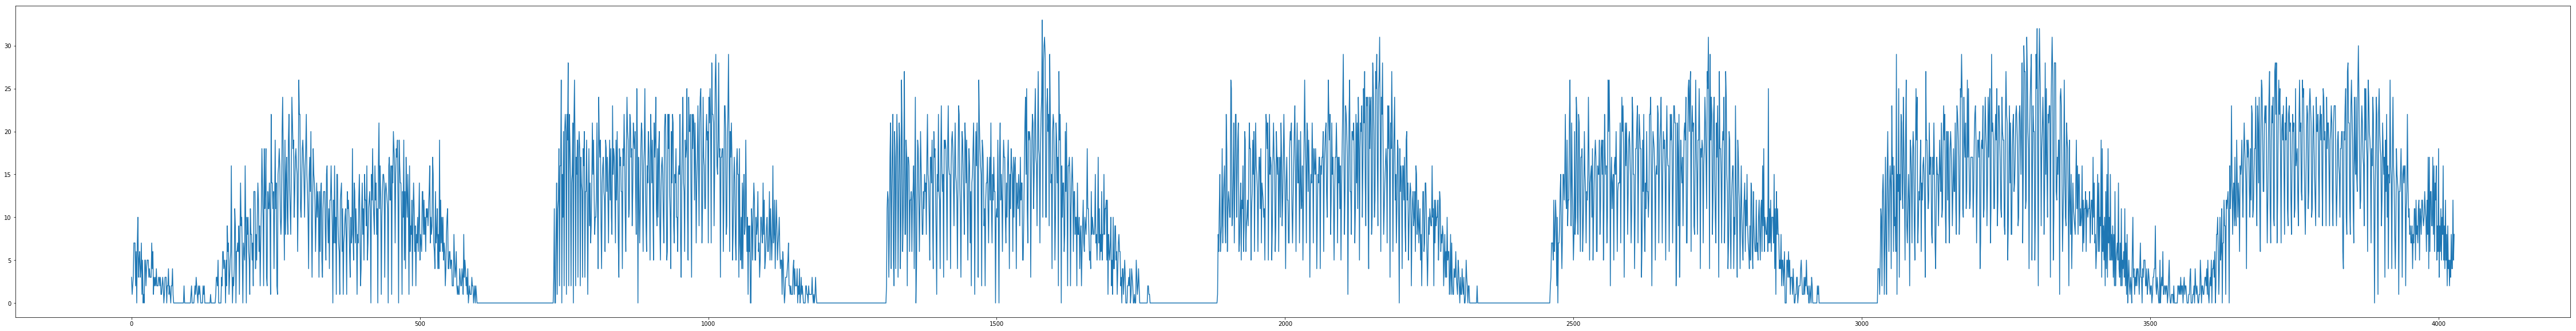

In [75]:
def get_flow (data):
  """ Extract flow from data
  
  This will transform the time series of register cars that passed in a array of
  flow per 'timeInterval' seconds.
  """
  
  date = np.asarray(data['Date'])
  time = np.asarray(data['Time'])
  speed = np.asarray(data['Speed'])
  
  sz = len(speed)
  dateControl = date[0] #seta o controle de data com o primeiro dia do chunk
  timeBlock = FLOW_INTERVAL
  countFlow = 0
  accSpeed = 0
  flowData = []
  

  for i in range(sz):
    if time[i] >= timeBlock: # init a new time block
      flowData.append((date[i], timeBlock, countFlow, accSpeed / countFlow)) 
      timeBlock += FLOW_INTERVAL
      countFlow = 0
      accSpeed = 0
      
    if date[i] > dateControl: # reset on day change
      dateControl = date[i]
      timeBlock = FLOW_INTERVAL 
      countFlow = 0
      accSpeed = 0
      
    if time[i] < timeBlock: # add car on flow
      countFlow += 1
      accSpeed += speed[i]

  #df_flow = pd.DataFrame(flowData, columns = ["Day", "TimeBlock", "Flow", "Average Speed"])
  
  return [f for d, t, f, v in flowData ]


raw_seq = get_flow(data)

plot_flow(raw_seq)

# Prepare for dataset for training

+ Adjust the dataset
+ Split the dataset
+ Create storage for the results

In [0]:
def split_sequence(sequence, n_steps, n_future):
  """ Split a univariate sequence into samples
  
  This function will split a sequence into many samples in the form of two
  arrays. The first array will have as elements arrays of size n_step and the 
  second array will have as elements a integer. 
  Example:
  
  split_sequence([1, 2, 3, 4, 5], 3) #=> ([[1, 2, 3], [2, 3, 4]], [4, 5])
  """
  
  n = len(sequence)
  X, Y = list(), list()
  
  for i in range(n):
    # find the end of this pattern
    end_ix = i + n_steps

    # check if we are beyond the sequence
    if end_ix + n_future > n-1:
      break

    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + n_future]
    X.append(seq_x)
    Y.append(seq_y)

  return np.array(X), np.array(Y)


def reshape_flow (raw_seq):  
  # split into samples
  X, Y = split_sequence(raw_seq, N_STEPS, N_FUTURE)

  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], N_FEATURES))
  
  return X, Y


X, Y = reshape_flow(raw_seq)

TEST_SIZE = len(X) // K_FOLD_SIZE

X_train, Y_train, X_test, Y_test = X[:TEST_SIZE], Y[:TEST_SIZE], X[TEST_SIZE:], Y[TEST_SIZE:]

# GRU

RMSE: 6.931883508009195
MSE: 48.051008968609864
MAE: 5.338565022421525
Max Error: 27.0


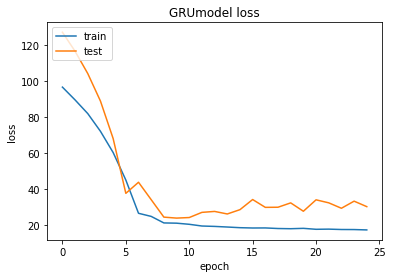

<Figure size 7200x7200 with 0 Axes>

In [77]:
def gru (X_train, Y_train, X_test, Y_test): 
  # define model
  model = Sequential()
  model.add(GRU(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  # fit model
  hist = model.fit(X_train, Y_train, validation_split=VALIDATION_SPLIT, batch_size=64, epochs=25, verbose=0) # verbose = 2
  
  Y_hat = model.predict(X_test, verbose=0) # verbose = 2
  
  print_metrics(Y_hat.round().flatten().tolist(), Y_test.tolist())
  plot_history(hist, "GRU")

gru(X_train, Y_train, X_test, Y_test)


# GRU with K-fold

In [78]:
def gru_k (X, Y): 
  # define model
  model = Sequential()
  model.add(GRU(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  # fit model
  res = 0.0

  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
  for i in range(1, K_FOLD_SIZE):
    train_sz = TEST_SIZE * i
    test_sz = train_sz + TEST_SIZE

    hist = model.fit(X[:train_sz], Y[:train_sz], validation_split=VALIDATION_SPLIT, batch_size=64, epochs=15, verbose=0) # verbose = 2
    
    Y_hat = model.predict(X[train_sz:test_sz], verbose=0) # verbose = 2
        
    res += np.sqrt(sklm.mean_squared_error(Y[train_sz:test_sz], Y_hat))

  print(f"K-validated RMSE: {res / (K_FOLD_SIZE-1)}")


gru_k(X, Y)

K-validated RMSE: 6.063439358738115


# LSTM



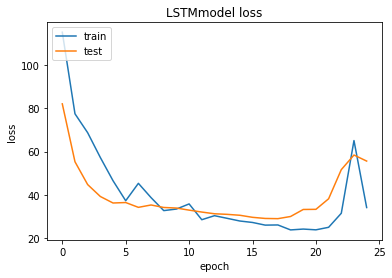

<Figure size 7200x7200 with 0 Axes>

RMSE: 8.002627091071057
MSE: 64.0420403587444
MAE: 6.003363228699552
Max Error: 32.0


In [79]:
def lstm (X_train, Y_train, X_test, Y_test): 
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  # fit model
  hist = model.fit(X_train, Y_train, validation_split=VALIDATION_SPLIT, batch_size=64, epochs=15, verbose=0) # verbose = 2
  
  Y_hat = model.predict(X_test, verbose=2) # verbose = 2

  plot_history(hist, "LSTM")
  print_metrics(Y_hat.round().flatten().tolist(), Y_test.tolist())
  
  

lstm(X_train, Y_train, X_test, Y_test)

# LSTM with K-Fold

In [80]:
def lstm_k (X, Y): 
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  # fit model
  res = 0.0

  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
  for i in range(1, K_FOLD_SIZE):
    train_sz = TEST_SIZE * i
    test_sz = train_sz + TEST_SIZE

    hist = model.fit(X[:train_sz], Y[:train_sz], validation_split=VALIDATION_SPLIT, batch_size=64, epochs=25, verbose=0) # verbose = 2
    
    Y_hat = model.predict(X[train_sz:test_sz], verbose=0) # verbose = 2
        
    res += np.sqrt(sklm.mean_squared_error(Y[train_sz:test_sz], Y_hat))

  print(f"K-validated RMSE: {res / (K_FOLD_SIZE-1)}")



lstm_k(X, Y)

K-validated RMSE: 5.982423850731273


# RNN

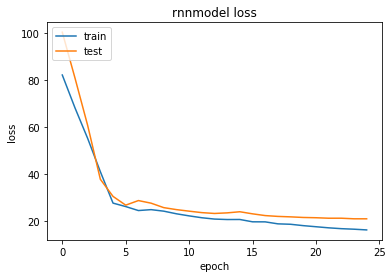

<Figure size 7200x7200 with 0 Axes>

RMSE: 6.145060723902444
MSE: 37.76177130044843
MAE: 4.619955156950673
Max Error: 27.0


In [81]:
def rnn (X_train, Y_train, X_test, Y_test): 
  # define model
  model = Sequential()
  model.add(SimpleRNN(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  # fit model
  hist = model.fit(X_train, Y_train, validation_split=VALIDATION_SPLIT, batch_size=64, epochs=25, verbose=0) # verbose = 2
  
  Y_hat = model.predict(X_test, verbose=0) # verbose = 2
  
  plot_history(hist, "rnn")
  print_metrics(Y_hat.round().flatten().tolist(), Y_test.tolist())


rnn(X_train, Y_train, X_test, Y_test)

# RNN with K-fold

In [82]:
def rnn_k (X, Y): 
  # define model
  model = Sequential()
  model.add(SimpleRNN(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  # fit model
  res = 0.0

  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
  for i in range(1, K_FOLD_SIZE):
    train_sz = TEST_SIZE * i
    test_sz = train_sz + TEST_SIZE

    hist = model.fit(X[:train_sz], Y[:train_sz], validation_split=VALIDATION_SPLIT, batch_size=64, epochs=25, verbose=0) # verbose = 2
    
    Y_hat = model.predict(X[train_sz:test_sz], verbose=0) # verbose = 2
        
    res += np.sqrt(sklm.mean_squared_error(Y[train_sz:test_sz], Y_hat))

  print(f"K-validated RMSE: {res / (K_FOLD_SIZE-1)}")


rnn_k(X, Y)

K-validated RMSE: 5.581028606208203
